# UROP 1100 - Victoria A. Junaedi
Code from https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
from keras import backend as K
import quandl

#  Getting the data from Quandl
and determining other parameters

In [6]:
quandl.ApiConfig.api_key = 'ETPyWitxJn3wiSRvxUjk'
seq_len = 22
shape = [seq_len, 9, 1]
neurons = [256, 256, 32, 1]
dropout = 0.3
decay = 0.5
epochs = 90
stock_name = 'AAPL'

# Pulling the data from Quandl

In [7]:
def get_stock_data(stock_name, normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = quandl.get_table('WIKI/PRICES', ticker = stock_name)
    df.drop(['ticker', 'open', 'high', 'low', 'close', 'ex-dividend', 'volume', 'split_ratio'], 1, inplace=True)
    df.set_index('date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'adj_open': 'Open', 'adj_high': 'High', 'adj_low': 'Low', 'adj_volume': 'Volume', 'adj_close': 'Adj Close'}, inplace=True)
    
    # Percentage change
    df['Pct'] = df['Adj Close'].pct_change()
    df.dropna(inplace=True)
    
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['Adj Close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
        df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
        df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
        df['Volume'] = min_max_scaler.fit_transform(df.Volume.values.reshape(-1,1))
        df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
        df['Pct'] = min_max_scaler.fit_transform(df['Pct'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
                
    # Move Adj Close to the rightmost for the ease of training
    adj_close = df['Adj Close']
    df.drop(labels=['Adj Close'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [8]:
df = get_stock_data(stock_name, ma=[50, 100, 200]) # putting 50 days, 100 days, and 200 days moving average

# Visualizing the data

In [9]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['Pct'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()

                Open      High       Low    Volume       Pct      50ma  \
date                                                                     
1981-09-30  0.000383  0.000393  0.000402  0.006603  0.618942  0.000777   
1981-10-01  0.000383  0.000393  0.000402  0.008103  0.609620  0.000759   
1981-10-02  0.000499  0.000510  0.000520  0.005935  0.705957  0.000747   
1981-10-05  0.000546  0.000567  0.000568  0.005673  0.645236  0.000735   
1981-10-06  0.000546  0.000544  0.000556  0.003687  0.601324  0.000721   

               100ma     200ma  Adj Close  
date                                       
1981-09-30  0.001069  0.001108   0.000400  
1981-10-01  0.001056  0.001102   0.000400  
1981-10-02  0.001045  0.001097   0.000517  
1981-10-05  0.001035  0.001092   0.000564  
1981-10-06  0.001024  0.001086   0.000553  


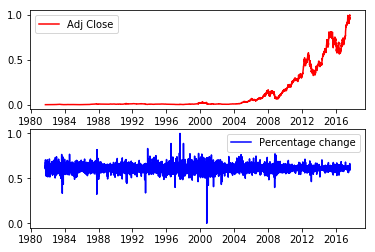

In [10]:
plot_stock(df)

# Split training and testing

In [14]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    result = []

    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days

    result = np.array(result)
    row = round(0.8 * result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(round(0.9 * result.shape[0])))
    print ("Amount of testing data = {}".format(round(0.1 * result.shape[0])))

    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price

    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

In [15]:
X_train, y_train, X_test, y_test = load_data(df, seq_len)

Amount of features = 9
Amount of training data = 8116
Amount of testing data = 902


In [16]:
def build_model(shape, neurons, dropout, decay):
    model = Sequential()

    model.add(LSTM(neurons[0], input_shape=(shape[0], shape[1]), return_sequences=True))
    model.add(Dropout(dropout))

    model.add(LSTM(neurons[1], input_shape=(shape[0], shape[1]), return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [19]:
model = build_model(shape, neurons, dropout, decay)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 22, 256)           272384    
_________________________________________________________________
dropout_9 (Dropout)          (None, 22, 256)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 805,953
Trainable params: 805,953
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.33,
    verbose=1)

Train on 4833 samples, validate on 2381 samples
Epoch 1/90
4833/4833 [==============================] - 221s - loss: 1.7195e-06 - acc: 2.0691e-04 - val_loss: 4.2531e-04 - val_acc: 0.0000e+00
Epoch 2/90
4833/4833 [==============================] - 65s - loss: 1.4646e-06 - acc: 2.0691e-04 - val_loss: 4.4214e-04 - val_acc: 0.0000e+00
Epoch 3/90
4833/4833 [==============================] - 45s - loss: 1.3664e-06 - acc: 2.0691e-04 - val_loss: 4.0085e-04 - val_acc: 0.0000e+00
Epoch 4/90
4833/4833 [==============================] - 34s - loss: 1.3177e-06 - acc: 2.0691e-04 - val_loss: 4.0098e-04 - val_acc: 0.0000e+00
Epoch 5/90
4833/4833 [==============================] - 42s - loss: 1.3640e-06 - acc: 2.0691e-04 - val_loss: 4.5309e-04 - val_acc: 0.0000e+00
Epoch 6/90
4833/4833 [==============================] - 39s - loss: 1.6622e-06 - acc: 2.0691e-04 - val_loss: 2.5077e-04 - val_acc: 0.0000e+00
Epoch 7/90
4833/4833 [==============================] - 43s - loss: 1.8572e-06 - acc: 2.0691e-04 - 

4833/4833 [==============================] - 35s - loss: 3.4161e-07 - acc: 2.0691e-04 - val_loss: 2.2549e-04 - val_acc: 0.0000e+00
Epoch 59/90
4833/4833 [==============================] - 35s - loss: 3.2322e-07 - acc: 2.0691e-04 - val_loss: 2.1233e-04 - val_acc: 0.0000e+00
Epoch 60/90
4833/4833 [==============================] - 39s - loss: 3.2407e-07 - acc: 2.0691e-04 - val_loss: 1.8858e-04 - val_acc: 0.0000e+00
Epoch 61/90
4833/4833 [==============================] - 39s - loss: 3.1981e-07 - acc: 2.0691e-04 - val_loss: 2.9947e-04 - val_acc: 0.0000e+00
Epoch 62/90
4833/4833 [==============================] - 38s - loss: 3.5781e-07 - acc: 2.0691e-04 - val_loss: 3.2347e-04 - val_acc: 0.0000e+00
Epoch 63/90
4833/4833 [==============================] - 36s - loss: 3.8653e-07 - acc: 2.0691e-04 - val_loss: 3.7861e-04 - val_acc: 0.0000e+00
Epoch 64/90
4833/4833 [==============================] - 36s - loss: 4.0401e-07 - acc: 2.0691e-04 - val_loss: 3.4895e-04 - val_acc: 0.0000e+00
Epoch 65/90

# Result

In [29]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00008 MSE (0.01 RMSE)
Test Score: 0.04678 MSE (0.22 RMSE)


(8.0843266326197558e-05, 0.046781160641552473)

# Prediction vs Real Results

In [30]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

In [31]:
p = percentage_difference(model, X_test, y_test)

In [32]:
def denormalize(stock_name, normalized_value):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = quandl.get_table('WIKI/PRICES', ticker = stock_name)
    df.drop(['ticker', 'open', 'high', 'low', 'close', 'ex-dividend', 'volume', 'split_ratio'], 1, inplace=True)
    df.set_index('date', inplace=True)
    
    # Renaming all the columns so that we can use the old version code
    df.rename(columns={'adj_open': 'Open', 'adj_high': 'High', 'adj_low': 'Low', 'adj_volume': 'Volume', 'adj_close': 'Adj Close'}, inplace=True)
    
    df.dropna(inplace=True)
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)

    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
      
    return new

In [33]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')
    plt2.show()

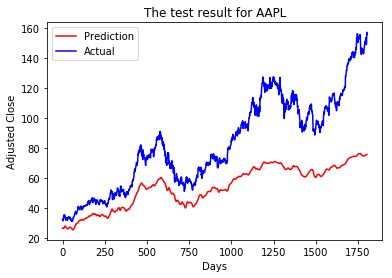

In [34]:
plot_result(stock_name, p, y_test)